# Project- House Prices: Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

The dataset contains 79 explanatory variables that describe alsmost every aspect of residential homes in Ames, Iowa. It's up to me to predict the pricing of houses based on the given dataset. The data is split into a train and test data set for me to train and test on. This dataset is part of a kaggle competition in which the principles of stacking, blending and ensembling techniques can be learned.

# Importing Required libraries

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score, train_test_split
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error, roc_auc_score,mean_absolute_error


# Data Collection

The data (as previously mentioned) is split into a train and test file with both the features and target variable available in the train.csv file to train on and only the features (without the target variable) in the test set. Although I have loaded the files, it is still necessary to also load them in R, which takes a few seconds.
The data can be found here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [63]:
train= pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [64]:
train.head(3) 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [65]:
print(train.shape)
print(test.shape)

#print(train.info())
print("Sum of numerical feature",train.dtypes[train.dtypes != "object"].count())
print("Sum of catgorical feature",train.dtypes[train.dtypes == "object"].count())

(1460, 81)
(1459, 80)
Sum of numerical feature 38
Sum of catgorical feature 43


# Data Visuallization & EDA
**Numercal Feature**

In [66]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Heat Map for Correlation
- Heat Map:Plot rectangular data as a color-encoded matrix.

to understand the distribution and quality of the data so that I can improve the modeling process.

**first Will see the correlation**

- I will focus on the numeric features and see in what way they are related to the target variable. To do this, a correlation matrix is often the first step just to see what is exactly going on with the data. 
- After that, I will look into some individual plots showing more on the relationship between that feature and the target.



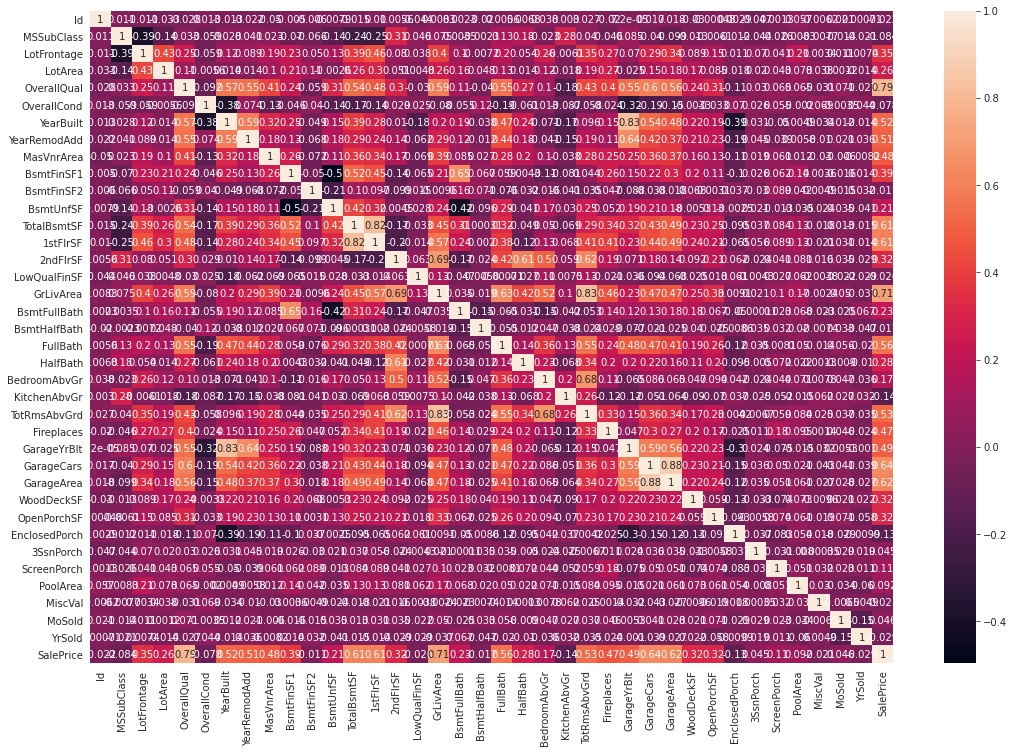

In [67]:
plt.figure(figsize=(18,12))
sns.heatmap(train.corr(),annot=True, )

**Observation**

There's a lot going on the in the correlation matrix. We see that there are some clusters that are highly correlated like GarageArea and GarageCars, which makes sense since having a garage that can hold more cars would likely also have a greater area. It is possible that there's some multicollinearity which affects the results.

Next, let's take a look at the features that are highly correlated with each other and look at those in more detail. I will select features that have a pearson's correlation of .7 or more


In [68]:
# Show highest correlation in the correlation matrix
correlation=train.corr().abs()
unstacked = correlation.unstack()
sort = unstacked.sort_values(kind="quicksort")
sort[(sort < 1) & (sort > 0.7)]

SalePrice     GrLivArea       0.708624
GrLivArea     SalePrice       0.708624
SalePrice     OverallQual     0.790982
OverallQual   SalePrice       0.790982
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
TotRmsAbvGrd  GrLivArea       0.825489
GrLivArea     TotRmsAbvGrd    0.825489
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
dtype: float64

*observation*

- There is some multicollinearity within the "Garage" features.
- SalePrice is higly correlated with OverallQual and GrLivArea
- Some people have bought a house without a garage and built the garage in later, which is why the correlation isn't 1
- Next, I will look at all the features that have a high correlation with SalePrice

In [69]:
sort['SalePrice'][sort['SalePrice']>0.6]

1stFlrSF       0.605852
TotalBsmtSF    0.613581
GarageArea     0.623431
GarageCars     0.640409
GrLivArea      0.708624
OverallQual    0.790982
SalePrice      1.000000
dtype: float64

*observation*

- The overall quality of the house has the highest correlation with the sale price. 
- The Garage seems to be an important feature, as well as the number of floors and whether it has a basement or not. 
- Although we have a lot of numbers telling us a lot of things, it would be more intuitive if the data was actually visualized.
- The type of relation is not clear purely based on pearson's r, thus I will use a pairplot to plot all features that are highly correlated with SalePrice.



## Pairplot
- Plot pairwise relationships in a dataset.
- By default, this function will create a grid of Axes such that each numeric variable in data will by shared in the y-axis across a single row and in the x-axis across a single column. The diagonal Axes are treated differently, drawing a plot to show the univariate distribution of the data for the variable in that column.

- It is also possible to show a subset of variables or plot different variables on the rows and columns.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 576x432 with 0 Axes>

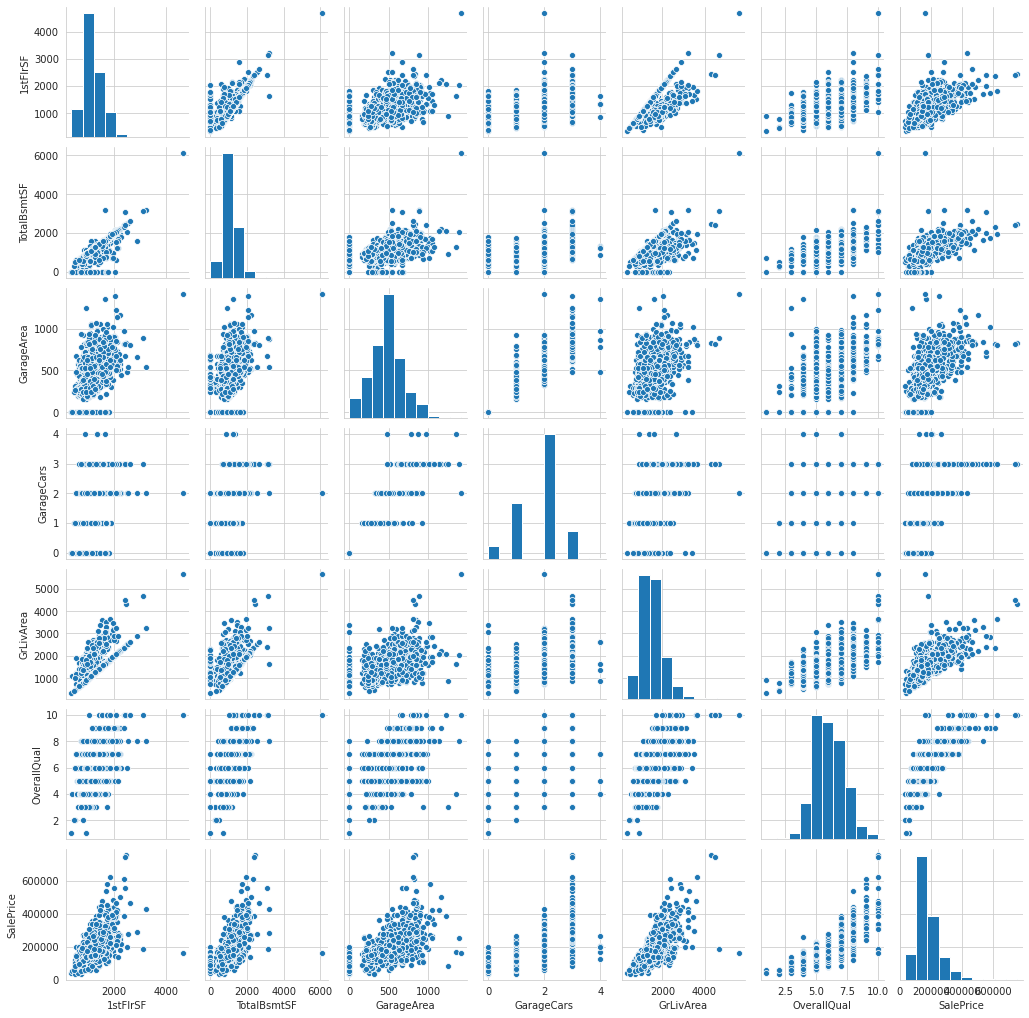

In [70]:
sns.set_style("whitegrid")
cols = sort['SalePrice'][sort['SalePrice']>0.6].index
plt.figure(figsize=(8,6))
sns.pairplot(train[cols], size = 2)

Although we now can clearly see the relationships, I also notice that a lot of features have some heteroscedasticity and some are not normally distributed. It might be worth to look into those features in more detail

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'YearBuilt_Garage vs House')

<Figure size 432x288 with 0 Axes>

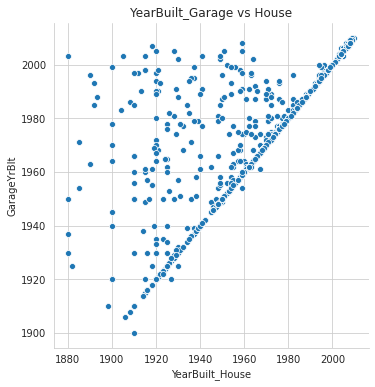

In [71]:
plt.figure()
sns.pairplot(train,x_vars=["YearBuilt"], y_vars='GarageYrBlt', size=5)#,kind='scatter' or 'reg')
plt.xlabel("YearBuilt_House")
plt.ylabel("GarageYrBlt")
plt.title("YearBuilt_Garage vs House")

here we can see most garages are built the same year as the house. However, some people either extended their garage or didn't have one and built that later. Everything on the line are the houses that had a garage from the beginning and most other point are those garages that were built later than the house.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

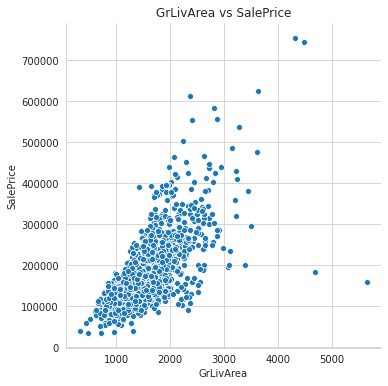

In [72]:
plt.figure()
sns.pairplot(train,x_vars=["GrLivArea"], y_vars='SalePrice', size=5)#,kind='scatter' or 'reg')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("GrLivArea vs SalePrice")
plt.show()

**There are two things that you should see immediately:**

1. There are two outliers on the far right (which we will deal with at a later stage)
2. There is some heteroscedasticity going on (which we will also deal with later)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

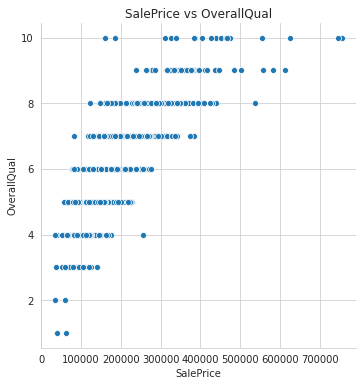

In [73]:
plt.figure()
sns.pairplot(train,x_vars=["SalePrice"], y_vars='OverallQual', size=5)#,kind='scatter' or 'reg')
plt.xlabel("SalePrice")
plt.ylabel("OverallQual")
plt.title("SalePrice vs OverallQual")
plt.show()

There clearly seems to be some relationship between overal quality and the sales price of the house such that an increase in sales price suggest an increase in overal quality.

## Displot
- Flexibly plot a univariate distribution of observations.
- To visuallize series data such as list,1d
- This function combines the matplotlib hist function (with automatic calculation of a good default bin size) with the seaborn :func:kdeplot and :func:rugplot functions. It can also fit scipy.stats distributions and plot the estimated PDF over the data.

**sns.distplot(a, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None,kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)**

bins : argument for matplotlib hist(), or None, optional
- Specification of hist bins. If unspecified, as reference rule is used that tries to find a useful default.  

hist : bool, optional
- Whether to plot a (normed) histogram.

kde : bool, optional
- Whether to plot a gaussian kernel density estimate. 

rug : bool, optional
- Whether to draw a rugplot on the support axis. 

**Exploration of the target variable "SalePrice" and plot its distribution to gain some information.**

we can see that the target variable "SalePrice" has a skewed distribution. Because I will be predicting a continuous feature, I will be using regressors which perform better if the target variable has a normal distribution with little to no skewdness. Thus, it is important to remember that in a later stage the data needs to be normalized.

Text(0.5, 1.0, 'Sale_Price_distribution')

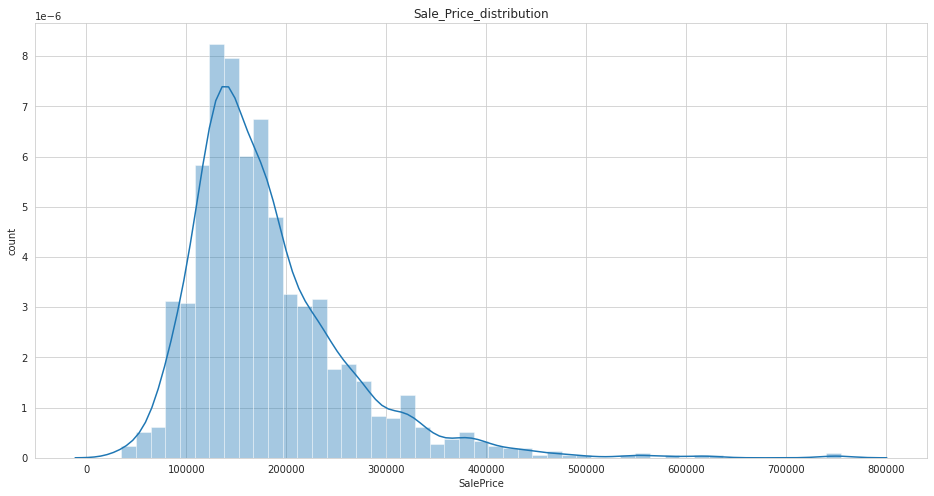

In [74]:
plt.figure(figsize=(16,8))
sns.distplot(train.SalePrice)
plt.xlabel("SalePrice")
plt.ylabel("count")
plt.title("Sale_Price_distribution")

we can see that the target variable "SalePrice" has a skewed distribution. Because I will be predicting a continuous feature, I will be using regressors which perform better if the target variable has a normal distribution with little to no skewdness. Thus, it is important to remember that in a later stage the data needs to be normalized.



# Data Visullization_Categorical Features

Categorical features have been missing from the visualisation so far. Since there are too many combinations of features to visualize, I will focus on the categorical features that may (according to my intuition) be related to SalesPrice. Below is a list of categorical features in the dataset.



In [75]:
train.dtypes[train.dtypes == "object"]

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

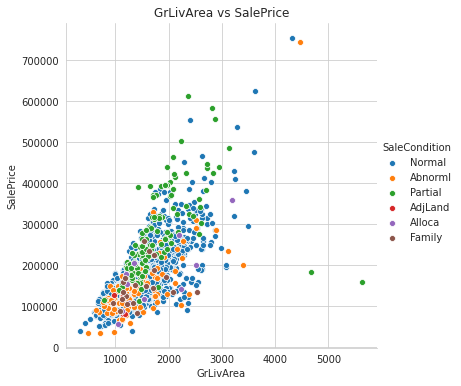

In [76]:
plt.figure()
sns.pairplot(train,x_vars=["GrLivArea"], y_vars=['SalePrice'], hue="SaleCondition",size=5)#,kind='scatter' or 'reg')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("GrLivArea vs SalePrice")
plt.show()

The graph doesn't give much information. It may be then that the salecondition doens't influence the relationship between living area and saleprice. The main conclusion is that most houses seem to be of condition "Normal". Perhaps we see something different for neighborhood.



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

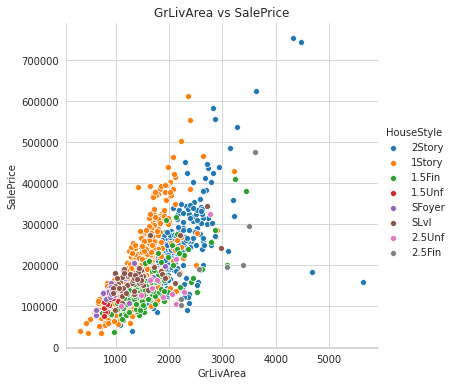

In [77]:
plt.figure()
sns.pairplot(train,x_vars=["GrLivArea"], y_vars='SalePrice', hue="HouseStyle",size=5)#,kind='scatter' or 'reg')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("GrLivArea vs SalePrice")
plt.show()

There's definitely something different going on here. The 1 story houses are according to the plot the most expensive houses for each square feet of living area. You would get more area per dollar if you would buy a 2 story house.


# Feature Engineering

Below points are observed during the exploration that I need to work on:

- There were some outliers
- The target feature is not normally distributed
- Some features showed heteroscedasticity 
- Multicollinearity
 - Although multicollinearity was found in some features, I did not find any improvement in the scores if I deleted those features. Therefore, I simply let them be.

Furthermore, I will be looking at:
- Variance of features
- Missing Values

## Outliers
In this machine learning task, it will be likely that I'll be using some form of regression analysis. These kind of methods are very sensitive to outliers, which may decrease the models accuracy. Therefore, I'll be looking for any outliers and remove them if neccesary.




/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

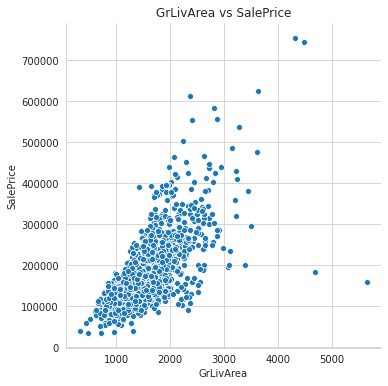

In [78]:
plt.figure()
sns.pairplot(train,x_vars=["GrLivArea"], y_vars=['SalePrice'],size=5)#,kind='scatter' or 'reg')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("GrLivArea vs SalePrice")
plt.show()

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. Seeing the trends in the plot above I believe these two points to be outliers and not representative for the entire dataset. Thus, my initial conclusion is to delete those outliers


In [79]:
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

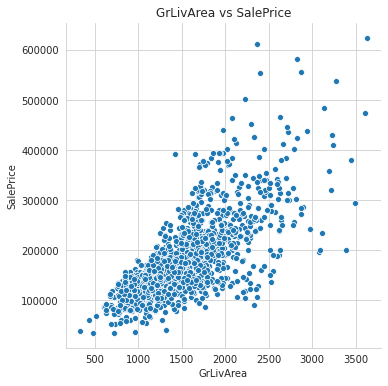

In [80]:
plt.figure()
sns.pairplot(train,x_vars=["GrLivArea"], y_vars=['SalePrice'],size=5)#,kind='scatter' or 'reg')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("GrLivArea vs SalePrice")
plt.show()

now plot seems to look a lot better and more representative of the data. However, we also see the shape of a cone in the plot, which may suggest that there is something going on with the distribution of the variables. Next, I'll take a look at the distribution of the target variable.

As a side note, the graph does display some heteroscedasticity which we will have to look into later (the cone-shape).


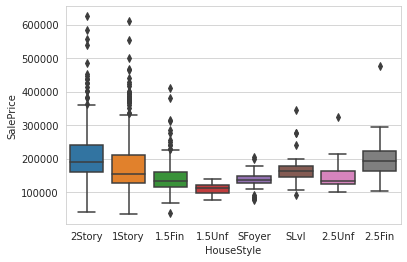

In [81]:
sns.boxplot(data=train,x='HouseStyle',y='SalePrice')

**Combining Features**

The data that was given was split into a test and train part. However, if I would want to transform categorical labels to numbers and I would do that only for the train set, then there might exist some levels/labels in the test set which we do not know. Therefore, I merge the test and train data so that I can get dummies (which I will do later) and create numbers for all labels. Furthermore, now I can also look for missing values in the test set.

In [82]:
features_all = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

## Hadling With Missing Value

observed many features, many don't have any values and are reported as NaN. In this dataset I find it highly unlikely that it was possible to report a value for everyone of the 81 features. Thus, I will create a list of the names of the columns that have missing values (solely based on NaN). This list can then be used to decide on what to do with those values.

In [83]:
def count_missing_data(df):
    """ Counts the missing values for each features
        and display the Total and the Percentage
    """
    # Calculates the total number of missing values for each feature
    total = df.isnull().sum().sort_values(ascending=False)
    
    # Calculates the percentage of missing values for each features
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    
    # Combines the percentage and totals
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    # Only returns data that have missing values
    return missing_data[missing_data['Percent']>0]

print("Number of features with missing values: {}".format(len(count_missing_data(features_all))))
count_missing_data(features_all)

Number of features with missing values: 34


,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageCond,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageFinish,159,0.054545


I will fill the missing values for the categorical features with the median using the function below.



In [84]:
def fillna_numerica_average(df):
    """ Fills the numeric features that contain 
        NaN with the average in those columns
    """
    # Get features that contain missing values
    features_with_nan = count_missing_data(df).index 
    
    # Get numeric features that contain missing values
    numeric_missing_features = df[features_with_nan].dtypes[df.dtypes != "object"].index 
    
    # Fill each missing values for the numeric features with the corresponding median
    for feature in numeric_missing_features:
        df[feature].fillna(df[feature].median(), inplace=True)
        
fillna_numerica_average(features_all)

In [85]:
# Shows the missing values again, but seeing as we have filled all numerical features, the categorical features are left
list_missing_data = count_missing_data(features_all)
print("Number of features with missing values: {}".format(len(list_missing_data)))
print("Categorical features")
list_missing_data

Number of features with missing values: 23
Categorical features


,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
GarageCond,159,0.054545
GarageFinish,159,0.054545
GarageQual,159,0.054545
GarageType,157,0.053859
BsmtExposure,82,0.028130


I've tried filling the missing values for the categorical features with the mode, but that didn't help the score. Thus, I simply dropped all categorical features that have missing values.

In [86]:
features_all = features_all.fillna(features_all.mean())

In [87]:
features_all.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000
mean,57.133791,68.940652,10133.648714,6.083705,5.565009,1971.271698,1984.240480,100.599314,438.074099,49.633276,560.606175,1048.366038,1156.821269,334.741338,4.700858,1496.263465,0.428816,0.061063,1.566381,0.379417,2.859348,1.044597,6.445626,0.595197,1978.130017,1.765352,472.171698,93.503945,47.268611,23.130017,2.605832,16.084391,1.899828,50.895712,6.215094,2007.793482
std,42.546667,20.739112,7806.198515,1.403444,1.113718,30.290998,20.897341,176.978829,442.797984,169.285205,439.632387,427.674616,383.956821,426.116353,46.428331,491.239383,0.523956,0.245153,0.551377,0.502692,0.822707,0.214603,1.562047,0.643945,24.869817,0.760987,214.461434,126.455095,67.139563,64.282620,25.205266,56.219760,33.020598,567.788382,2.712242,1.315615
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7474.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1125.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9450.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.000000,988.000000,1082.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,479.500000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,78.000000,11554.500000,7.000000,6.000000,2001.000000,2004.000000,162.500000,732.000000,0.000000,803.500000,1300.000000,1383.500000,703.500000,0.000000,1742.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


# Data Preprocessing

While EDA-Displot we have observed that Clearly, the distribution of target variable is skewed to the right, which means that we have to transform the current distribution to one that has a normal distribution. Below we will simply do that by computing the log(1+x) of all data points within the target variable.

In [88]:
# #log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

Text(0.5, 1.0, 'Sale_Price_distribution')

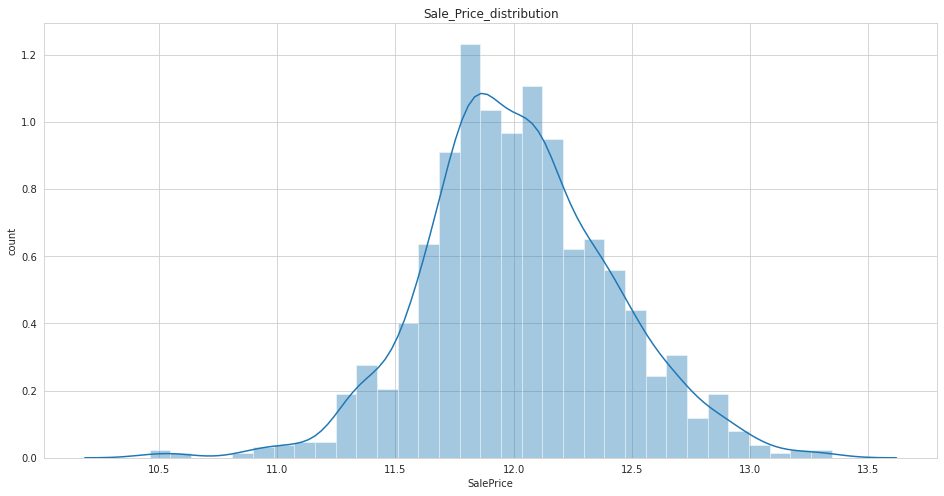

In [89]:
plt.figure(figsize=(16,8))
sns.distplot(train.SalePrice)
plt.xlabel("SalePrice")
plt.ylabel("count")
plt.title("Sale_Price_distribution")

This already looks a lot better! Next, it would be wise to do the same for the independent variables that have a high skewedness.


### Transforming Categorical Features

If I would simply label the categorical features, then that would imply some meaning in the distances between data points, that is not the case. Thus, I choose to make dummy features of all categorical features so that they will displayed as having some category or not.

In [90]:
features_all = pd.get_dummies(features_all)

### Scaling Numerical Features
Scaling all the numeric features so that they will have a better distribution

In [91]:
scaler = StandardScaler()
scaler.fit(features_all)
scaled = scaler.transform(features_all)

# Train Test Split

Because we concatenated the data in an earlier stage, we can simply use the shape of the train data to mark where we have added the test data so that we can split all_features into X_train and X_test. That way, we have the same data that was in the training dataset and in the testing dataset.

In [233]:
target = train['SalePrice']
X_train = features_all[:train.shape[0]]
test_data = features_all[train.shape[0]:]

In [140]:
print(np.sum(features_all.isnull().sum()))#final check to find availability of missing value in dataframe
#features_all.isnull().sum()#final check to find availability of missing value in columns
print("shape of features_all",features_all.shape)
print("target",target.shape)
print("shape of X_train",X_train.shape)
print("shape of X_test",X_test.shape)

0
shape of features_all (2915, 287)
target (1456,)
shape of X_train (1456, 287)
shape of X_test (1459, 287)


In [234]:
x_train,x_test,y_train,y_test=train_test_split(X_train,target,test_size=.20,cv=5)

# Modelling 

**Ridge Regression**

Ridge regression is a method that redues the size of coefficients in a linear regression using the L2 norm (see below) and thereby reduces the complexity in the model. Furthermore, it helps in overfitting and dealing with outliers.

The L2 norm means that the weight (which you find in a linear regression) are penalized if they were to grow to large. This way you won't put too much emphasis on a few features, but you make sure the weights are similar. Therefore, it also helps with generalization and makes it more robust.

**Lasso**

Lasso (Least Absolute Shrinkage and Selection Operator) also uses regulization to prevent overfitting. In contrast, however, it can set the weights of coefficients to zero, whereas ridge regression can only bring those close to zero but never zero. Therefore, lasso often is a model that is less complex since it can fully remove features. In our case, it helps with the highly correlated predictors.

**ElasticNet**

Elastic net solves the limitations of lasso and ridge, while also including each as special cases. It uses both the L1 and the L2 norm. In layman-terms, it combines the penalties of lasso and ridge and it often prefered above both models.

**Gradient Booster**

The gradient booster basically takes many weak predictive models and boosts it into a stronger one, which represents an ensemble of weak models. Often, the weak model can be any model that works a little better than a random guess.

**XGBoost**

XGBoost is very similar to a gradient booster in that it follows gradient boosting. XGBoost uses a more regularized model formalization to control over-fitting, which gives it better performance.

## Best parameters for each models_GridSearch
Here i am using grid search to find the best parameters for each model. Each model has its own parameter grid, which can be used to specify the parameters. I suggest you don't execute this part, seeing as it will take forever to find all the best parameters

In [206]:
def grid_search(param_grid, estimator):#estimator:The object to use to fit the data.

    grid = GridSearchCV(estimator,param_grid,refit=True,verbose=3)
    grid.fit(X_train, target)
    print(grid.best_params_)
    print(grid.best_estimator_)

In [207]:
param_grid_gradient = {'n_estimators': [500, 3000], 
                       'learning_rate': np.arange(0.01, 0.1, 0.01), 
                       'max_depth': [1, 3, 5, 7], 
                       'min_samples_leaf': [10, 15, 20],
                       'min_samples_split': [10, 15, 20]}

param_grid_xgb = {'colsample_bytree' :[0.2],
                 'gamma': [0.0],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'min_child_weight': [1.5],
                 'n_estimators': np.arange(5000, 30000, 5000),                                                          
                 'reg_alpha': [0.9],
                 'reg_lambda': [0.6],
                 'subsample': [0.2, 0.3],
                'max_depth': [1, 2, 3, 4]}

param_grid_lasso = {'alpha':np.arange(0.0001, 0.001, 0.0001), 
                    'max_iter': np.arange(10000, 50000, 10000)}

param_grid_net = {'alpha': np.arange(0.0001, 0.001, 0.0001)}

param_grid_ridge = {'alpha': np.arange(0.1, 0.9, 0.1), 
                    'kernel': ['polynomial'], 
                    'degree': [2], 
                    'coef0':[1.85]}

In [ ]:
#grid_search(param_grid_gradient, GradientBoostingRegressor())
# grid_search(param_grid_xgb, XGBRegressor())
# grid_search(param_grid_lasso, Lasso())
# grid_search(param_grid_net, ElasticNet())

# Model training

In [266]:
# Gradient Boosting
gradient = GradientBoostingRegressor(n_estimators = 3000, min_samples_leaf = 15, learning_rate = 0.05, max_features = 'sqrt',
                                      max_depth = 3, min_samples_split = 10, loss = 'huber')
gradient.fit(X_train, target)

# XGBoost
xgb = xgb.XGBRegressor(n_estimators = 30000, colsample_bytree = 0.2, gamma = 0.0,  reg_lambda = 0.6,  min_child_weight = 1.5,
                  reg_alpha = 0.9, learning_rate = 0.01, max_depth = 4, subsample = 0.2, seed = 42, silent = 1)
xgb.fit(X_train, target)

# Lasso
lasso = Lasso(max_iter = 50000, alpha = 0.00098)
lasso.fit(X_train, target)

# ElasticNet
net = ElasticNet(alpha=0.001)
net.fit(X_train, target)

AttributeError: ignored

# Model evaluation

For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.

In [247]:
#cv: if None, to use the default 5-fold cross validation
#scoring: If None, the estimator’s score method is used.
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

print('XGBoost CV r2: {}'.format(cross_val_score(xgb, X_train,target,cv=5,scoring='r2')))
#print('Lasso CV CV r2: {}'.format(cross_val_score(lasso, X_train,target,cv=5,scoring='r2')))
#print('ElasticNet CV r2: {}'.format(cross_val_score(net, X_train,target,cv=5,scoring='r2')))
#print('Gradient CV r2: {}'.format(cross_val_score(gradient, X_train,target,cv=5,scoring='r2')))

XGBoost CV r2: [0.91938349 0.91837817 0.90435662 0.92001447 0.91108433]


# Model Prediction

In [ ]:
# Gradient Boosting
y_pred_gradient = gradient.predict(X_train)

# XGBoost
y_pred_xgb = xgb.predict(X_train)

# Lasso
y_pred_lasso = lasso.predict(X_train)

# ElasticNet
y_pred_net = net.predict(X_train)

In [251]:
# Averaging scores using weights
y_pred = (0.70*y_pred_xgb + 0.05*y_pred_lasso + 0.15*y_pred_net + 0.10*y_pred_gradient)

Based on the prediction scores, I devised a ensemble of multiple predictors using certain weights. I found dat XGB and ElasticNet gave me the best scores, so I increased the weight of those predictors so that those would dominate the output. All the other predictors are then used to slightly adjust the dominating predictors to avoid overfitting.

# Model Submission with test.csv
Below is mostly the same code as above. The only change is that I predict the X_test instead of y so that I can submit my predictions. A file is created that is used for submission with the correct structure. It should be noted that since I've not set a seed, the results are somewhat randomized and the submission may slightly be different from the leaderboard score.


In [268]:
# Lasso
lasso = Lasso(max_iter = 50000, alpha = 0.00098)
lasso.fit(X_train, target)
y_pred_lasso = lasso.predict(test_data)

# ElasticNet
net = ElasticNet(alpha = 0.001)
net.fit(X_train, target)
y_pred_net = net.predict(test_data)

# XGBoost
xgb = xgb.XGBRegressor(n_estimators = 30000, colsample_bytree = 0.2, gamma = 0.0,  reg_lambda = 0.6,  min_child_weight = 1.5,
                       reg_alpha = 0.9, learning_rate = 0.01, max_depth = 4, subsample = 0.2, seed = 42, silent = 1)
xgb.fit(X_train, target)
y_pred_xgb = xgb.predict(test_data)

# Gradient boosting
gradient = GradientBoostingRegressor(n_estimators = 3000, min_samples_leaf = 15, learning_rate = 0.05, max_features = 'sqrt',
                                      max_depth = 3, min_samples_split = 10, loss = 'huber', random_state = 42)
gradient.fit(X_train, target)
y_pred_gradient = gradient.predict(test_data)


In [275]:
solution = pd.DataFrame({"id":test.Id, "SalePrice": np.expm1(y_pred_gradient)})
solution.to_csv("submission_v4g.csv", index = False)